In [15]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6

In [16]:
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [17]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [18]:
ts= data["#Passengers"]
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

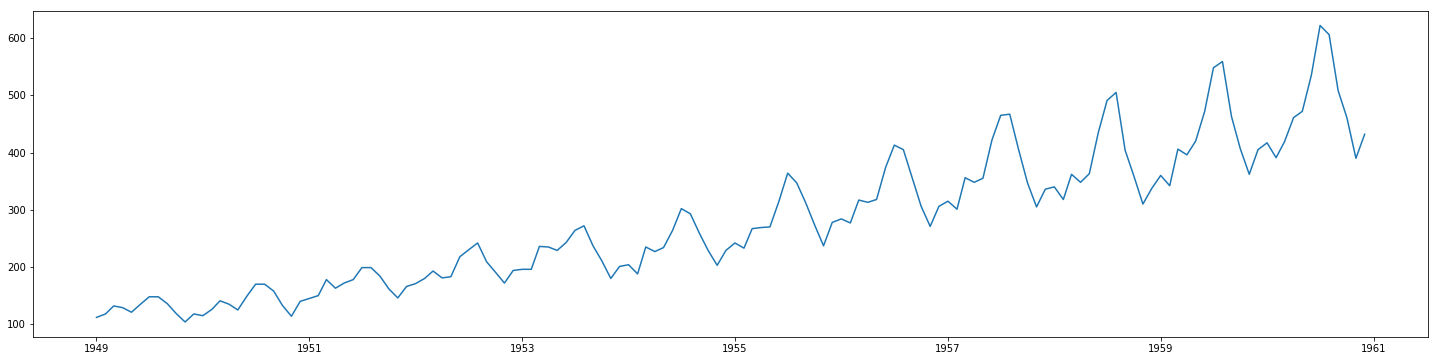

In [19]:
plt.plot(ts)

In [20]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [21]:
stationarity_test(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
dtype: float64


In [22]:
ts_log=np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
stationarity_test(ts_log_diff)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
Critical Value (5%)             -2.884398
dtype: float64


In [23]:
from statsmodels.tsa.stattools import acf,pacf
lag_acf= acf(ts_log_diff,nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20,method="ols")

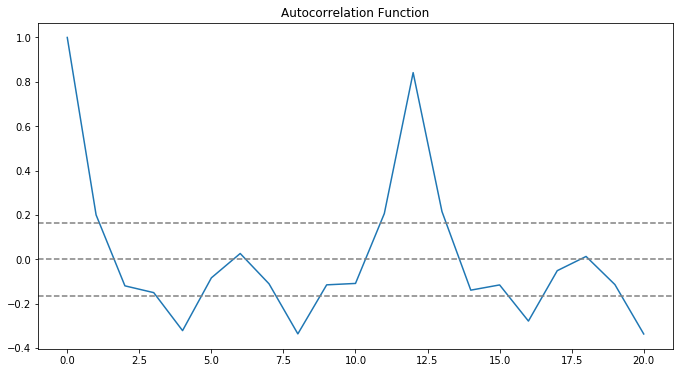

In [24]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_dif)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

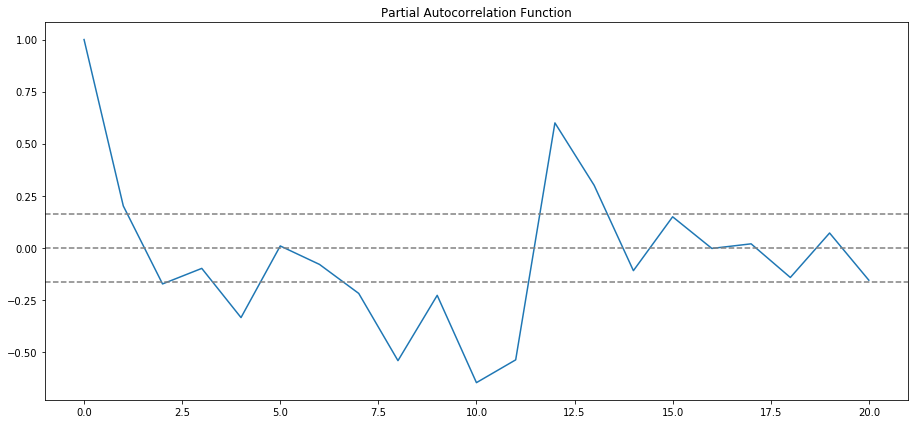

In [25]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


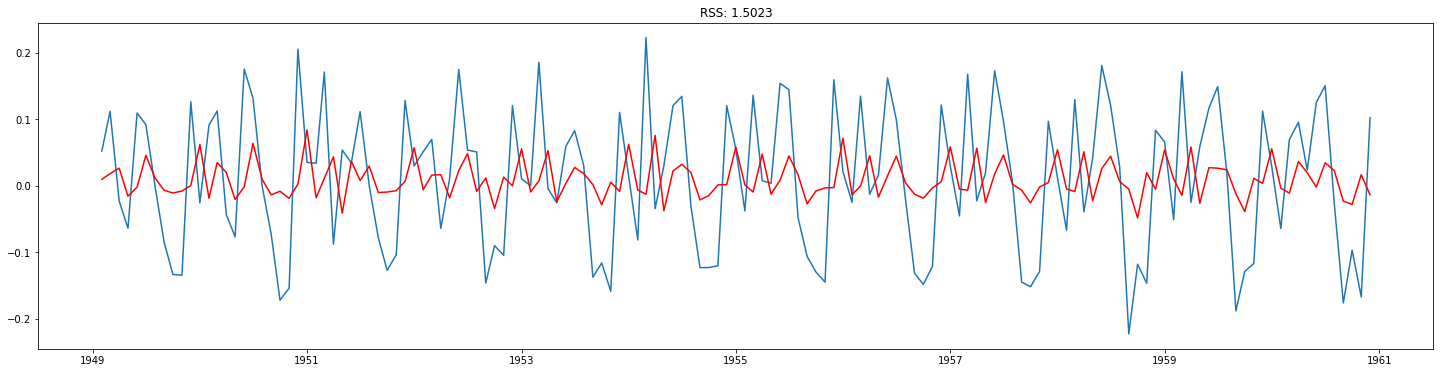

In [26]:
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(ts_log, order=(2, 1, 0)) 
results_AR = model1.fit(disp=-1) 
plt.plot(ts_log_dif)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_dif)**2))

In [27]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 122.802
Method:                       css-mle   S.D. of innovations              0.102
Date:                Thu, 10 Jan 2019   AIC                           -237.605
Time:                        22:23:14   BIC                           -225.753
Sample:                    02-01-1949   HQIC                          -232.789
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.009      1.048      0.296      -0.008       0.028
ar.L1.D.#Passengers     0.2359      0.083      2.855      0.005       0.074       0.398
ar.L2.D.#Passengers    -0.1725      0.083     -2.070      0.040      -0.336      -0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6838           -2.3088j            2.4079           -0.2042
AR.2            0.6838           +2.3088j            2.4079            0.2042
-----------------------------------------------------------------------------
"""

C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


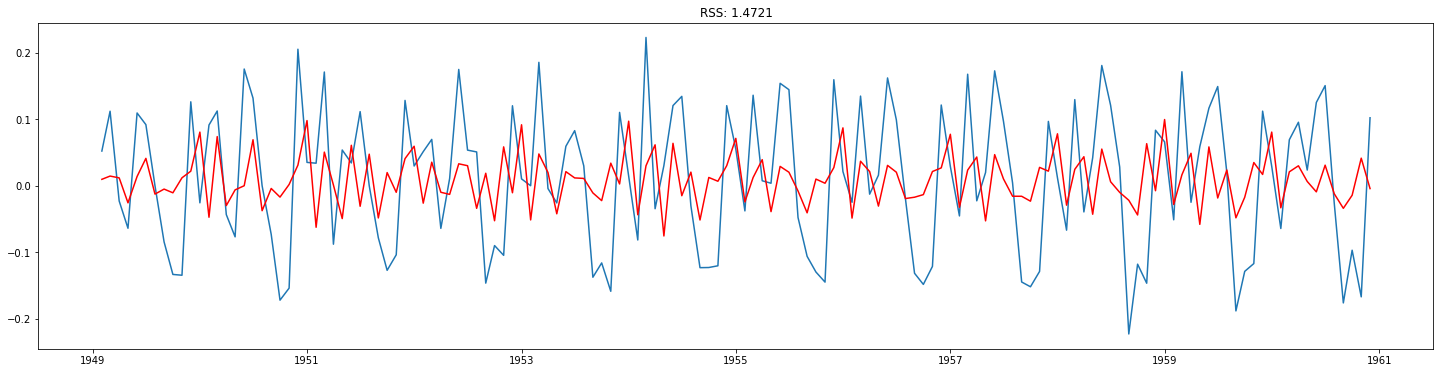

In [28]:
model2 = ARIMA(ts_log, order=(0, 1, 2)) 
results_MA = model2.fit(disp=-1) 
plt.plot(ts_log_dif)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_dif)**2))

C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


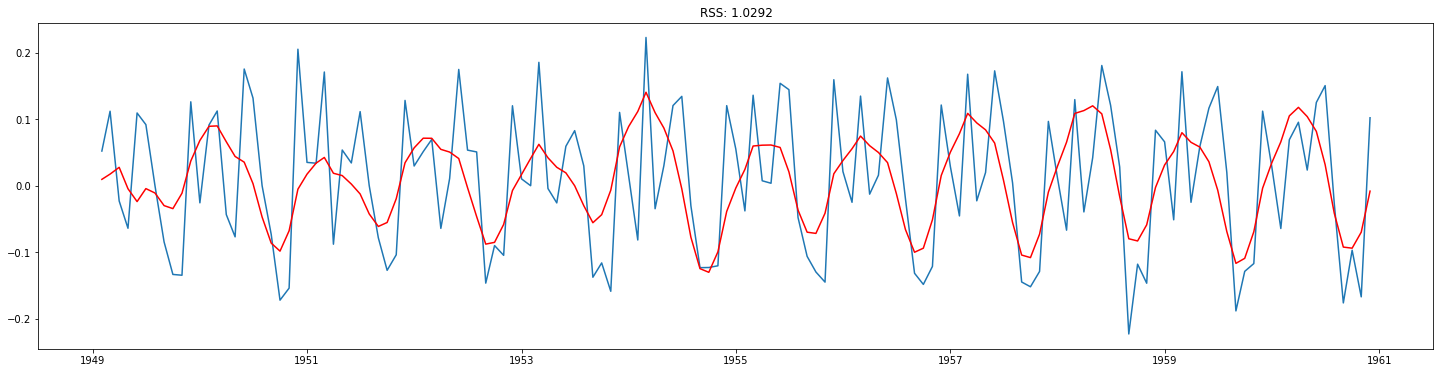

In [30]:
model3 = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model3.fit(disp=-1)  
plt.plot(ts_log_dif)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_dif)**2))

In [31]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Thu, 10 Jan 2019   AIC                           -287.281
Time:                        22:23:40   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passengers    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.#Passengers    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.#Passengers     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

In [32]:
predictions_ARIMA_dif= pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_dif.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [33]:
predictions_ARIMA_dif_cumsum = predictions_ARIMA_dif.cumsum()
print(predictions_ARIMA_dif_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [34]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_dif_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

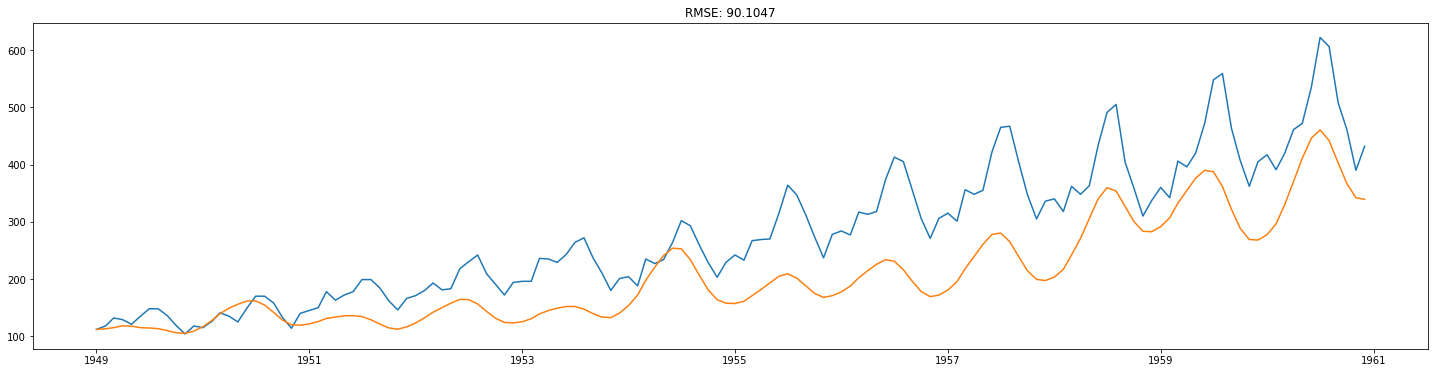

In [35]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [37]:
import statsmodels.tsa.api as smtsa
aic=[] 
for ari in range(1, 3): 
    obj_arima = smtsa.ARIMA(ts_log_diff, order=(ari,2,0)).fit(maxlag=30, method='mle', trend='nc') 
    aic.append([ari,2,0, obj_arima.aic])
print(aic)

[[1, 2, 0, -76.46506473849644], [2, 2, 0, -116.1112196485397]]


C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [38]:
import statsmodels.tsa.api as smtsa
aic=[] 
for ari in range(1, 3): 
     for maj in range(1,3): 
        arima_obj = smtsa.ARIMA(ts_log, order=(ari,1,maj)).fit(maxlag=30, method='mle', trend='nc') 
        aic.append([ari,1, maj, arima_obj.aic])
print(aic)

C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sinkur\AppData\Local\Continuum\anaconda3.1\envs\virtual_platform\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sin

[[1, 1, 1, -242.6262079840165], [1, 1, 2, -248.8648292320533], [2, 1, 1, -251.46351037666676], [2, 1, 2, -279.96951163008583]]
